In [1]:
import os
import time
import cv2
import numpy as np
import pandas as pd
import pickle as pkl
from matplotlib import pyplot as plt

import final_project.config as c
from final_project.models.Frame import Frame
from final_project.models.Matcher import Matcher, DEFAULT_MATCHER

In [2]:

def measure_inliers_within_frame(n: int, m: Matcher, verbose=False):
    assert 0 < n <= c.NUM_FRAMES
    start = time.time()

    match_count = np.zeros(n)
    feature_count = np.zeros(n)
    for i in range(n):
        img_l, img_r = c.read_images(i)
        kps_l, descs_l = m._detector.detectAndCompute(img_l, None)
        kps_r, descs_r = m._detector.detectAndCompute(img_r, None)
        all_matches = m.match_descriptors(descs_l, descs_r)
        features, descriptors = m._find_frame_inliers(kps_l, kps_r, descs_l, all_matches)
        match_count[i] = len(all_matches)
        feature_count[i] = len(features)
        if i%500==0 and verbose:
            elapsed = time.time() - start
            print(f"\tFinished {i} Frames in {elapsed:.2f} seconds")

    elapsed = time.time() - start
    return match_count, feature_count, elapsed


In [3]:
N = c.NUM_FRAMES

# default values
print("M0")
m0 = Matcher(detector_type=c.DEFAULT_DETECTOR_NAME, matcher_type=c.DEFAULT_MATCHER_NAME, use_crosscheck=c.SHOULD_CROSS_CHECK, use_2nn=c.SHOULD_USE_2NN)
match_count0, feature_count0, elapsed0 = measure_inliers_within_frame(N, m0, verbose=True)
print(f"Finished m0 in {(elapsed0/60):.2f} minutes\n")

# expected to be the fastest
print("M1")
m1 = Matcher(detector_type="orb", matcher_type="bf", use_crosscheck=False, use_2nn=False)
match_count1, feature_count1, elapsed1 = measure_inliers_within_frame(N, m1, verbose=True)
print(f"Finished m1 in {(elapsed1/60):.2f} minutes\n")

# expected to be slow
print("M2")
m2 = Matcher(detector_type="sift", matcher_type="bf", use_crosscheck=False, use_2nn=True)
match_count2, feature_count2, elapsed2 = measure_inliers_within_frame(N, m2, verbose=True)
print(f"Finished m2 in {(elapsed2/60):.2f} minutes\n")

# expected to be slow
print("M3")
m3 = Matcher(detector_type="sift", matcher_type="bf", use_crosscheck=True, use_2nn=False)
match_count3, feature_count3, elapsed3 = measure_inliers_within_frame(N, m3, verbose=True)
print(f"Finished m3 in {(elapsed3/60):.2f} minutes\n")

# expected to be slow
print("M4")
m4 = Matcher(detector_type="sift", matcher_type="flann", use_crosscheck=False, use_2nn=False)
match_count4, feature_count4, elapsed4 = measure_inliers_within_frame(N, m4, verbose=True)
print(f"Finished m4 in {(elapsed4/60):.2f} minutes")

M0
	Finished 0 Frames in 0.69 seconds
	Finished 500 Frames in 237.97 seconds
	Finished 1000 Frames in 579.72 seconds
	Finished 1500 Frames in 910.49 seconds
	Finished 2000 Frames in 1306.06 seconds
	Finished 2500 Frames in 1719.99 seconds
	Finished 3000 Frames in 2041.96 seconds
Finished m0 in 38.45 minutes

M1
	Finished 0 Frames in 1.99 seconds
	Finished 500 Frames in 27.26 seconds
	Finished 1000 Frames in 47.69 seconds
	Finished 1500 Frames in 64.67 seconds
	Finished 2000 Frames in 81.60 seconds
	Finished 2500 Frames in 98.38 seconds
	Finished 3000 Frames in 114.74 seconds
Finished m1 in 2.15 minutes

M2
	Finished 0 Frames in 0.20 seconds
	Finished 500 Frames in 126.82 seconds
	Finished 1000 Frames in 271.33 seconds
	Finished 1500 Frames in 415.41 seconds
	Finished 2000 Frames in 568.52 seconds
	Finished 2500 Frames in 701.43 seconds
	Finished 3000 Frames in 820.55 seconds
Finished m2 in 15.35 minutes

M3
	Finished 0 Frames in 0.28 seconds
	Finished 500 Frames in 118.93 seconds
	Fini

In [10]:
# save results
# TODO: make this less quick-and-dirty (MultiIndex columns, naming, etc.)

df = pd.DataFrame([match_count0, feature_count0, match_count1, feature_count1, match_count2, feature_count2, match_count3, feature_count3, match_count4, feature_count4]).T
df.columns=["M0_match_count", "M0_inlier_count", "M1_match_count", "M1_inlier_count", "M2_match_count", "M2_inlier_count", "M3_match_count", "M3_inlier_count", "M4_match_count", "M4_inlier_count"]
with open(os.path.join(c.DATA_WRITE_PATH, "matcher_comparison_results.pkl"), 'wb') as f:
    pkl.dump(df, f, protocol=-1)

s = pd.Series([elapsed0, elapsed1, elapsed2, elapsed3, elapsed4], index=[f"M{i}" for i in range(1, 6)], name="Runtime")
with open(os.path.join(c.DATA_WRITE_PATH, "matcher_comparison_runtime.pkl"), 'wb') as f:
    pkl.dump(s, f, protocol=-1)

print(f"M0:\tmean:\t{feature_count0.mean():.2f}\tstd:\t{feature_count0.std():.2f}\truntime:{elapsed0:.2f}")
print(f"M1:\tmean:\t{feature_count1.mean():.2f}\tstd:\t{feature_count1.std():.2f}\truntime:{elapsed1:.2f}")
print(f"M2:\tmean:\t{feature_count2.mean():.2f}\tstd:\t{feature_count2.std():.2f}\truntime:{elapsed2:.2f}")
print(f"M3:\tmean:\t{feature_count3.mean():.2f}\tstd:\t{feature_count3.std():.2f}\truntime:{elapsed3:.2f}")
print(f"M4:\tmean:\t{feature_count4.mean():.2f}\tstd:\t{feature_count4.std():.2f}\truntime:{elapsed4:.2f}")

M0:	mean:	661.50	std:	222.31	runtime:2306.87
M1:	mean:	214.27	std:	52.22	runtime:129.00
M2:	mean:	661.50	std:	222.31	runtime:920.85
M3:	mean:	774.51	std:	263.17	runtime:975.21
M4:	mean:	825.60	std:	275.43	runtime:2294.37


In [15]:
feature_count2.min(), feature_count2.max(), feature_count3.min(), feature_count3.max()

(226.0, 1558.0, 246.0, 1836.0)

<Figure size 432x288 with 0 Axes>

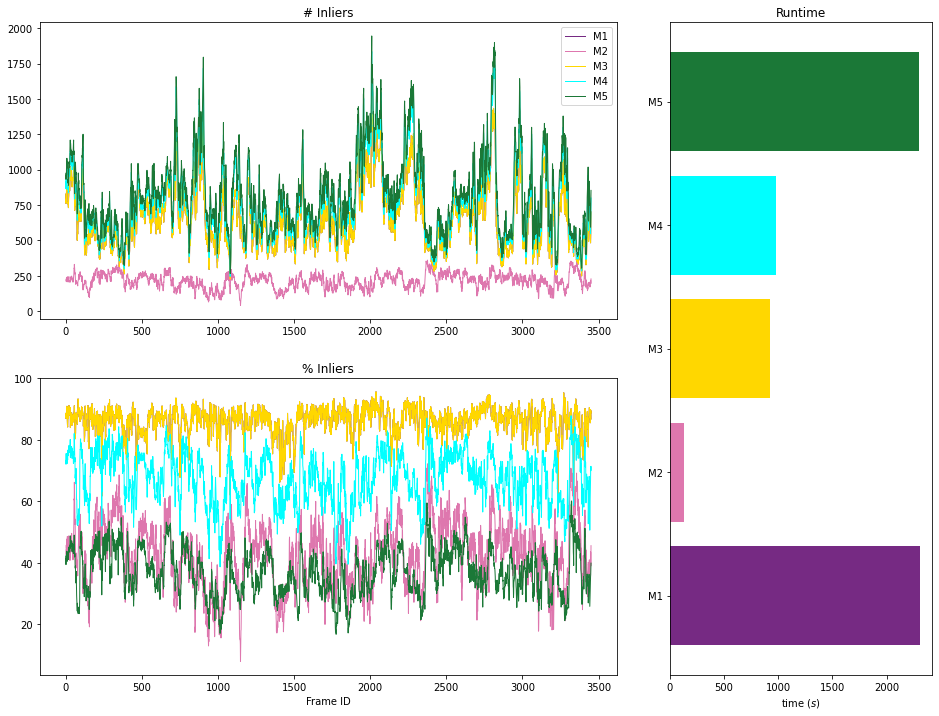

In [18]:
frame_ids = [i+1 for i in range(c.NUM_FRAMES)]
colorblind_friendly = ["#762a83", "#de77ae", "gold", "cyan", "#1b7837"]

plt.clf()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 12), sharex='col')
gs = axes[0, 0].get_gridspec()  # see tutorial: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_and_subplots.html

for i in range(len(axes)):
    for j in range(len(axes[i])):
        ax = axes[i][j]
        ax.remove()

top_left = fig.add_subplot(gs[0, :2])
bottom_left = fig.add_subplot(gs[1, :2])
right = fig.add_subplot(gs[:, 2])
# fig.tight_layout()

right.set_title("Runtime")
right.barh(y=[i for i in range(1,6)], width=[elapsed0, elapsed1, elapsed2, elapsed3, elapsed4],
            linewidth=0, color=colorblind_friendly, tick_label=[f"M{i}" for i in range(1, 6)])
right.set_xlabel("time ($s$)")

top_left.set_title("# Inliers")
top_left.plot(frame_ids, feature_count0, linewidth=1, c=colorblind_friendly[0], label="M1")
top_left.plot(frame_ids, feature_count1, linewidth=1, c=colorblind_friendly[1], label="M2")
top_left.plot(frame_ids, feature_count2, linewidth=1, c=colorblind_friendly[2], label="M3")
top_left.plot(frame_ids, feature_count3, linewidth=1, c=colorblind_friendly[3], label="M4")
top_left.plot(frame_ids, feature_count4, linewidth=1, c=colorblind_friendly[4], label="M5")
# axes[0, 0].set_xlabel("Frame ID")
top_left.legend()

bottom_left.set_title("% Inliers")
bottom_left.plot(frame_ids, 100 * np.divide(feature_count0, match_count0), linewidth=1, c=colorblind_friendly[0], label="M1")
bottom_left.plot(frame_ids, 100 * np.divide(feature_count1, match_count1), linewidth=1, c=colorblind_friendly[1], label="M2")
bottom_left.plot(frame_ids, 100 * np.divide(feature_count2, match_count2), linewidth=1, c=colorblind_friendly[2], label="M3")
bottom_left.plot(frame_ids, 100 * np.divide(feature_count3, match_count3), linewidth=1, c=colorblind_friendly[3], label="M4")
bottom_left.plot(frame_ids, 100 * np.divide(feature_count4, match_count4), linewidth=1, c=colorblind_friendly[4], label="M5")
bottom_left.set_xlabel("Frame ID")

plt.show()

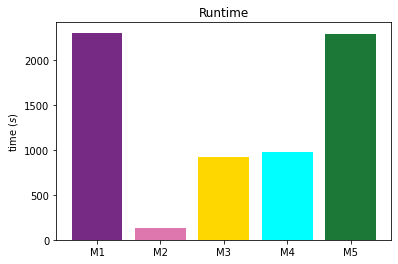

In [19]:
plt.clf()
plt.title("Runtime")
plt.bar(x=[i for i in range(1,6)], height=[elapsed0, elapsed1, elapsed2, elapsed3, elapsed4],
            linewidth=0, color=colorblind_friendly, tick_label=[f"M{i}" for i in range(1, 6)])
plt.ylabel("time ($s$)")
plt.show()

In [19]:
orb = cv2.ORB_create()
sift = cv2.SIFT_create()

def detect(detector, img_l, img_r):
    start = time.time()
    kps_l, descs_l = detector.detectAndCompute(img_l, None)
    kps_r, descs_r = detector.detectAndCompute(img_r, None)
    elapsed = time.time()
    return kps_l, descs_l, kps_r, descs_r, elapsed

orb_results = []
sift_results = []
for i in range(c.NUM_FRAMES):
    img_l, img_r = c.read_images(i)
    orb_results.append(detect(orb, img_l, img_r))
    sift
    orb_kps_l, orb_descs_l, orb_kps_r, orb_descs_r, orb_elapsed = detect(orb)
    sift_kps_l, sift_descs_l, sift_kps_r, sift_descs_r, sift_elapsed = detect(sift)